In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        print('Spectrum file missing...')
        return
    return lam,flux,fluxsig

def adapted_ch_cont(array,continuum,sigarray = None):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],10)
    cont = np.polynomial.chebyshev.chebval(lamgrid,p)
    contcorr = spec / cont
    if sigarray is not None:
        stdev = np.sqrt(1.0/sigarray)
        contsigarray = stdev / cont
        normivar = (1.0/contsigarray)**2
        return contcorr,normivar
    return contcorr

def norm_dataspec(array,sigarray=None):
    contcorr,contsig = adapted_ch_cont(array,continuum,sigarray)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    #contcorr[where] = 1
    return contcorr,contsig


In [61]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

In [62]:
from keras.regularizers import l2

In [60]:
help(keras.models.Model)

Help on class Model in module keras.engine.training:

class Model(keras.engine.network.Network)
 |  Model(*args, **kwargs)
 |  
 |  The `Model` class adds training & evaluation routines to a `Network`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.network.Network
 |      keras.engine.base_layer.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function or
 |              `Loss` instance. See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary o

In [8]:
sc = MinMaxScaler()
msc = StandardScaler()

In [9]:
filetable = Table.read('filetable.fits')
wdtable = Table.read('tremblay_final.fits')
print(len(wdtable))
wdtable = join(filetable,wdtable,keys = ['source_id'])

DA = (wdtable['spec_Teff'] < 40000)*(wdtable['spectral_class_1'] == 'DA')
wdtable = wdtable[DA]
print(len(wdtable))

5396
5229


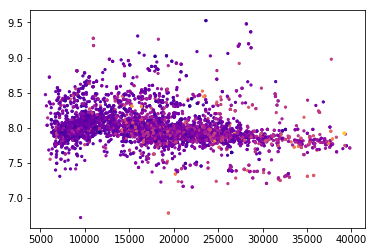

In [10]:
plt.scatter(wdtable['spec_Teff'],wdtable['spec_logg'], s = 5, c = wdtable['S/N_1'], vmax = 100, cmap = 'plasma')

In [11]:
interpfluxs = [];
sigs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    sig = spec[2]
    func2 = interp1d(lam,sig,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpsig = func2(lamgrid)
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)
    sigs.append(interpsig)

100%|██████████| 5229/5229 [06:36<00:00, 13.19it/s]


In [18]:
spectra = np.asarray(interpfluxs)
sigs = np.asarray(sigs)
lamgrid = np.arange(4000,8000)

In [19]:
wdtable['spectrum'] = spectra
wdtable['ivar'] = sigs

In [20]:
pixels = np.arange(0,4000)
continuum = (pixels > 2900) + (pixels < 2200)*(pixels > 1200) + (pixels < 650)*(pixels > 530) \
            + (pixels < 35)*(pixels > 20) + (pixels < 220)*(pixels > 200)
norms = [norm_dataspec(np.asarray(wdtable['spectrum'][ii]),np.asarray(wdtable['ivar'][ii])) for ii in range(len(wdtable))]
normspectra = np.asarray(norms)[:,0]
normivars = np.asarray(norms)[:,1]

where = (normspectra > 1.5) + (normspectra < 0)
normspectra[where] = 1

wdtable['normspectrum'] = normspectra
wdtable['normivar'] = normivars

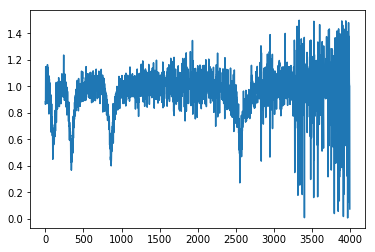

In [21]:
plt.plot(normspectra[464])

## RV Corr

In [22]:
alphaline = 6565
betaline = 4863
gammaline = 4342
deltaline = 4103

cores = (lamgrid == alphaline) + (lamgrid == betaline) + (lamgrid == gammaline) + (lamgrid == deltaline)
cores = cores.astype(int)

In [23]:
from PyAstronomy.pyasl import crosscorrRV, quadExtreme

In [24]:
rvcorrfluxs = [];
specrvs = [];
for ii in tqdm(range(len(wdtable))):
    spec = scipy.signal.medfilt(np.asarray(wdtable['normspectrum'][ii]),5)
    xcorrs = crosscorrRV(lamgrid[0:3000],1-spec[0:3000],lamgrid[0:3000],cores[0:3000], -500, 500, 10, 'doppler', skipedge = 25)
    corrs = xcorrs[1]
    rvs = xcorrs[0]
    try:
        specrv = quadExtreme(rvs,corrs, 'max', (10,10), fullOutput = True)[0]
    except:
        specrv = 0
    corrected_spec = dopplerShift(lamgrid,spec,specrv, edgeHandling = 'fillValue', fillValue = 1)
    func = interp1d(corrected_spec[1],corrected_spec[0],kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    rvcorrfluxs.append(interpflux)
    specrvs.append(specrv)
wdtable['rvcorr_normspectrum'] = np.asarray(rvcorrfluxs)
specrvs = np.asarray(specrvs)

100%|██████████| 5229/5229 [01:11<00:00, 73.46it/s]


### Bayesian NN

Text(0, 0.5, '')

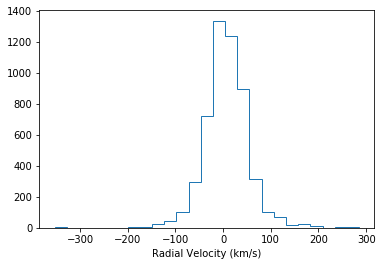

In [25]:
plt.hist(specrvs, bins = 25, histtype = 'step');
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('')

In [27]:
import astroNN

In [28]:
bgrid = np.linspace(np.min(wdtable['spec_Teff']),np.max(wdtable['spec_Teff']),25)
ggrid = np.linspace(np.min(wdtable['spec_logg']),np.max(wdtable['spec_logg']),25)
bint = bgrid[1]-bgrid[0]
gint = ggrid[1]-ggrid[0]

In [19]:
selections = [];
for i in tqdm(bgrid):
    for j in ggrid:
        square = (wdtable['spec_Teff'] > i)*(wdtable['spec_logg'] > j)*\
                (wdtable['spec_Teff'] < i+bint)*(wdtable['spec_logg'] < j+gint)
        if len(wdtable[square]) > 0:
            snidxs = np.argsort(wdtable[square]['S/N_1'])
            snmaxidxs = np.array(snidxs[-25:])
            for jj in snmaxidxs:
                selections.append(wdtable[square][int(jj)]['source_id'])

100%|██████████| 25/25 [03:40<00:00,  3.44s/it]


In [20]:
idxs = [];
for i in selections:
    idxs.append(np.argmax(wdtable['source_id'] == i))

In [21]:
testidxs = np.setxor1d(range(len(wdtable)),idxs)

In [22]:
wdtable_train = wdtable[idxs]
wdtable_test = wdtable[testidxs]

In [23]:
scale_dummy = np.asarray([[5000,6.5],[50000,9.5]])

In [24]:
X_train = np.asarray(wdtable_train['rvcorr_normspectrum'])
X_err = np.asarray( 1.0/np.sqrt(wdtable_train['normivar']))

y_train = np.asarray(np.stack((
    wdtable_train['spec_Teff'],
    wdtable_train['spec_logg']
))).T

sc = MinMaxScaler()
sc.fit(scale_dummy)

y_train = sc.transform(y_train)

X_test = np.asarray(wdtable_test['normspectrum'])

y_test = np.asarray(np.stack((
    wdtable_test['spec_Teff'],
    wdtable_test['spec_logg']
))).T

y_test = sc.transform(y_test)

In [25]:
spectral_error = np.mean(X_err,0)

In [50]:
where = np.isnan(X_test)
X_test[where] = 1

NameError: name 'X_test' is not defined

In [51]:
import astroNN.nn.layers

In [53]:
nmag = 2
H = 100

reg = 1e-10

def nn():
    x = Input(shape=(4000,))
    #x_noisy = astroNN.nn.layers.ErrorProp()(x)
    y = Dense(256,activation='relu', kernel_regularizer = l2(reg))(x)
    y = astroNN.nn.layers.MCDropout(0.01)(y)
    y = Dense(128,activation='relu', kernel_regularizer = l2(reg))(y)
    y = astroNN.nn.layers.MCDropout(0.01)(y)
    y = Dense(64,activation='relu',kernel_regularizer = l2(reg))(y)
    y = astroNN.nn.layers.MCDropout(0.01)(y)
    y = Dense(32,activation='relu',kernel_regularizer = l2(reg))(y)

    out = Dense(2,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model

history = np.asarray([]);
vhistory = np.asarray([]);
model = nn()
#model.load_weights('bayesnet.h5')
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1024256   
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 64)                0   

In [45]:
for i in tqdm(range(1025)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 100
    
    batch = 64
    
    h = model.fit(X_train,y_train, epochs = n_epochs, verbose = 0, batch_size = batch, validation_data = (X_test,y_test))
    history = np.append(history, h.history['loss'])
    vhistory = np.append(vhistory, h.history['val_loss'])
    #model.save_weights('bayesnet.h5')



  0%|          | 0/1025 [00:00<?, ?it/s]

Training meta-batch 0




  0%|          | 1/1025 [01:42<29:15:18, 102.85s/it]

Training meta-batch 1




  0%|          | 2/1025 [03:25<29:13:41, 102.86s/it]

Training meta-batch 2




  0%|          | 3/1025 [05:12<29:33:32, 104.12s/it]

Training meta-batch 3




  0%|          | 4/1025 [06:55<29:24:58, 103.72s/it]

Training meta-batch 4




  0%|          | 5/1025 [08:37<29:15:51, 103.29s/it]

Training meta-batch 5


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

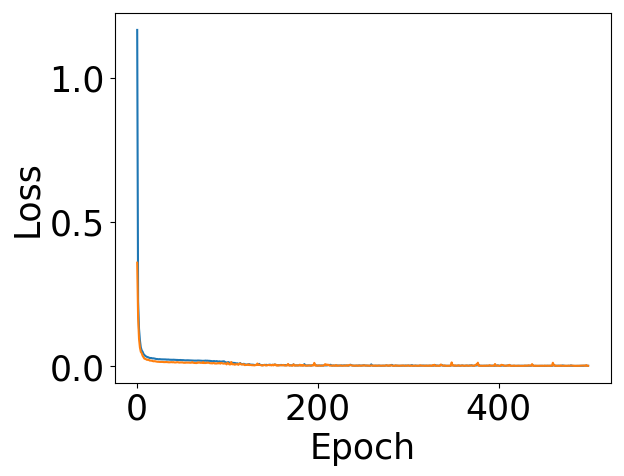

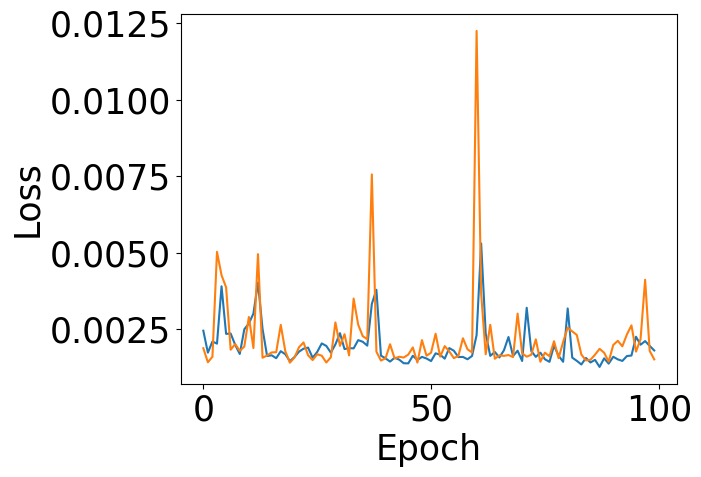

In [46]:
plt.figure()
plt.plot(history);
plt.plot(vhistory)
plt.xlabel('Epoch')
plt.ylabel('Loss')

r = 100
plt.figure()
plt.plot(history[-r:]);
plt.plot(vhistory[-r:]);
plt.xlabel('Epoch')
plt.ylabel('Loss')

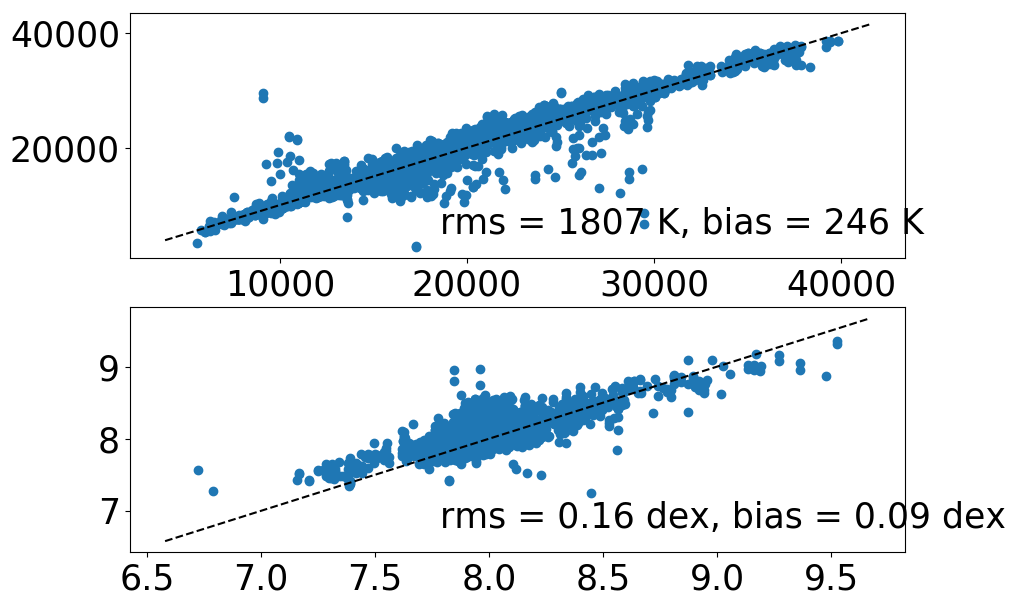

In [47]:
preds = (sc.inverse_transform(model.predict(X_test)))
truths = sc.inverse_transform(y_test)
plt.figure(figsize=(10,7))

f = plt.subplot(211)

plt.scatter(truths[:,0],preds[:,0])
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,0] - truths[:,0]
rms = np.sqrt(np.nanmean(resid**2))
bias = np.nanmean(resid)
plt.text(0.4,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)

f = plt.subplot(212)

plt.scatter(truths[:,1],preds[:,1])
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,1] - truths[:,1]
rms = np.sqrt(np.nanmean(resid**2))
bias = np.nanmean(resid)
plt.text(0.4,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);

In [48]:
def bootstrap(spectra):
    n_b = 10
    preds = np.asarray([sc.inverse_transform(model.predict(spectra)) for i in range(n_b)])
    return np.mean(preds,0),np.std(preds,0)


preds = bootstrap(X_test)[0]
errs = bootstrap(X_test)[1]

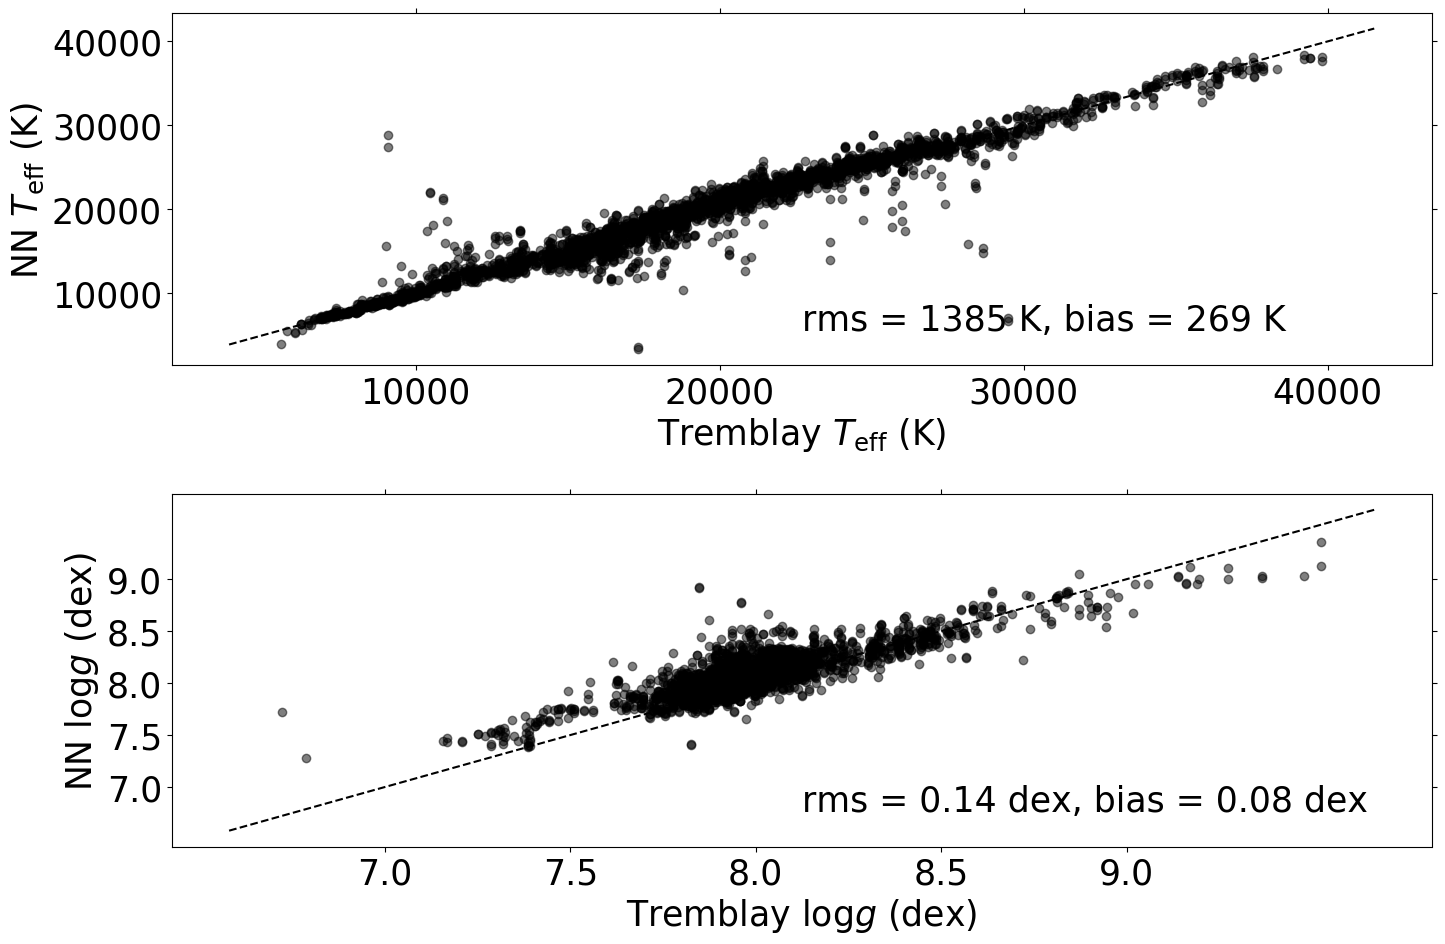

In [49]:
truths = sc.inverse_transform(y_test)

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 25})

f = plt.subplot(211)

plt.scatter(truths[:,0],preds[:,0],color='k',alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,0] - truths[:,0]
lowteffmask = truths[:,0] < 20000
rms = np.sqrt(np.nanmean(resid[lowteffmask]**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('NN $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,41000,10000));
f.xaxis.set_ticks(np.arange(10000,41000,10000));
f.tick_params(top = True,right = True)


f = plt.subplot(212)

plt.scatter(truths[:,1],preds[:,1],color='k', alpha = 0.5)
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,1] - truths[:,1]
rms = np.sqrt(np.nanmean(resid**2))
bias = np.nanmean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('NN $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));


plt.tight_layout()

plt.savefig('nn_pred.pdf')

2681


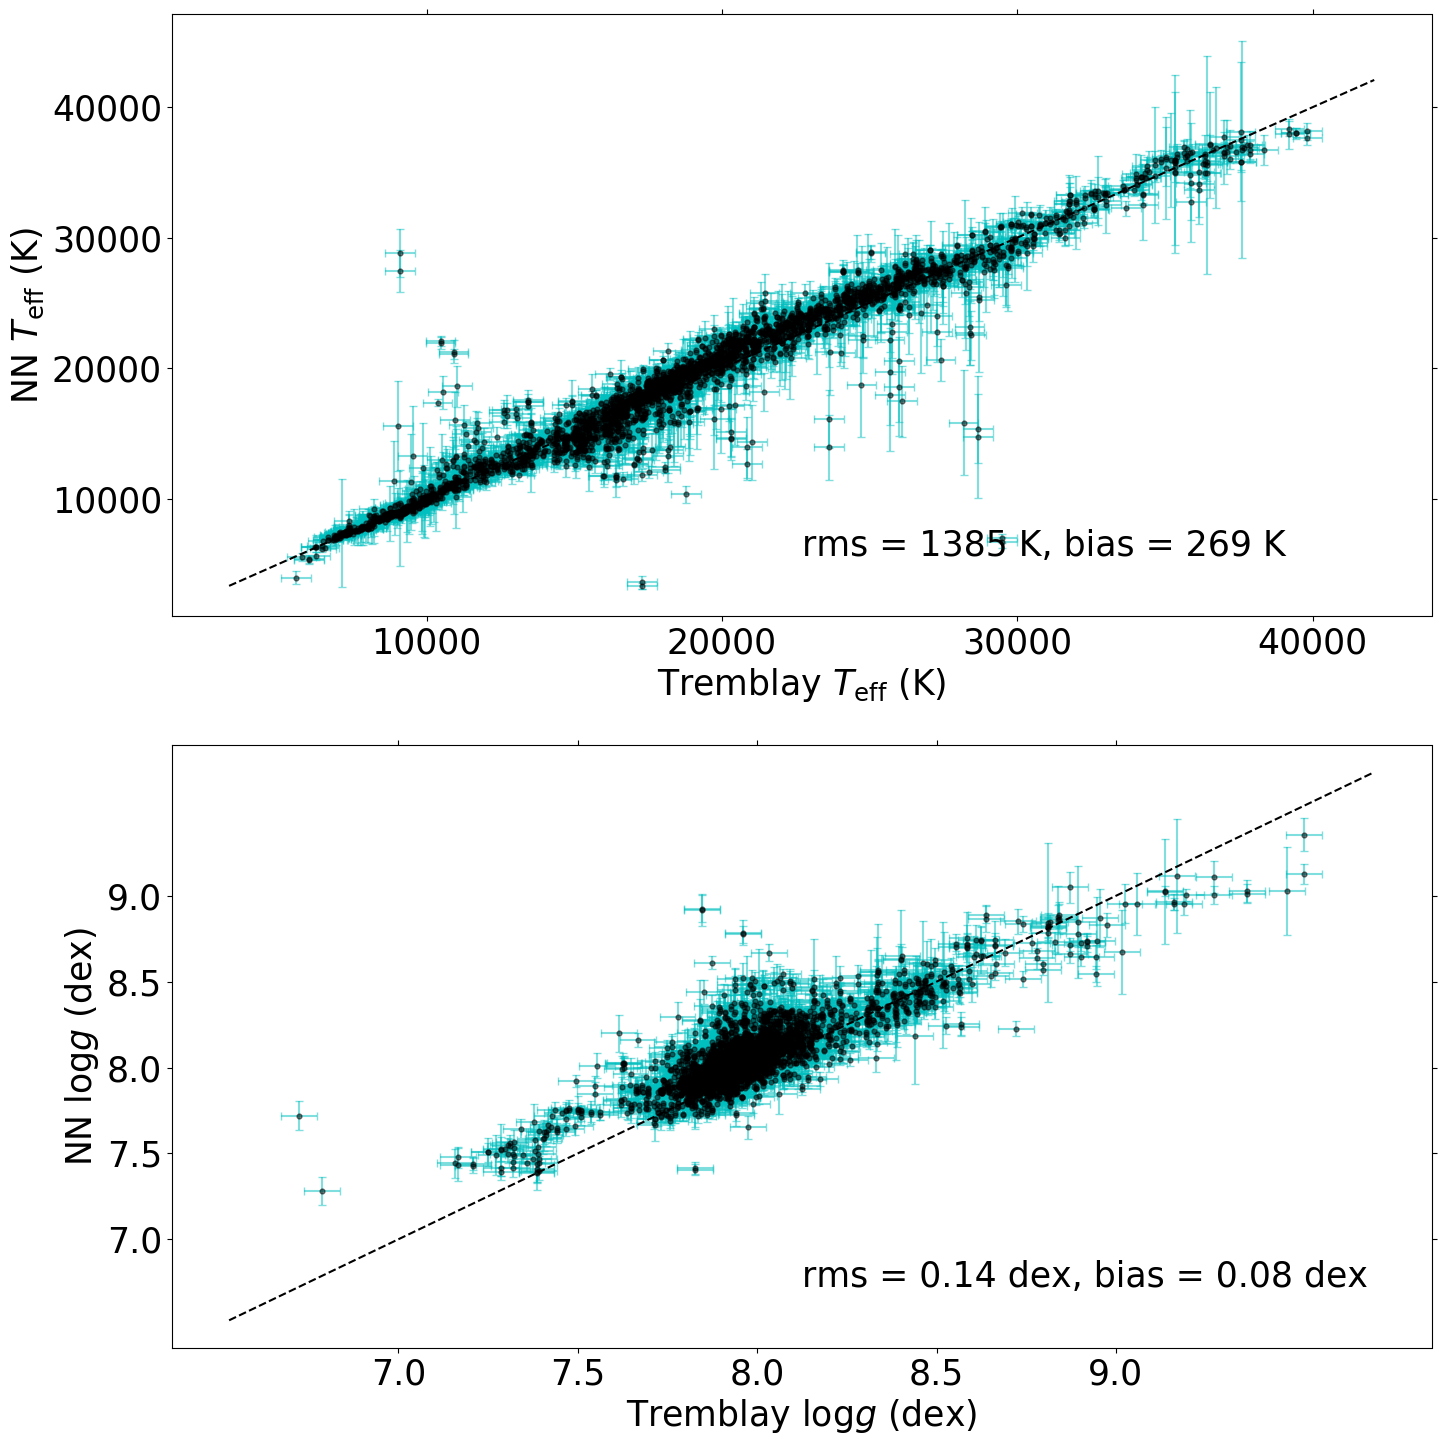

In [50]:
truths = sc.inverse_transform(y_test)

plt.style.use('default')
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 25})


f = plt.subplot(211)
plt.errorbar(truths[:,0],preds[:,0],color='k',alpha = 0.5, yerr = errs[:,0],
            linestyle = 'None', marker = '.',\
            ecolor = 'c', capsize = 3, markersize = 7, xerr = np.repeat(500,len(errs)))
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,0] - truths[:,0]
lowteffmask = truths[:,0] < 20000
rms = np.sqrt(np.mean(resid[lowteffmask]**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %i K, bias = %i K'%(rms,bias), transform = f.transAxes)
plt.xlabel('Tremblay $T_{\mathrm{eff}}$ (K)')
plt.ylabel('NN $T_{\mathrm{eff}}$ (K)')
f.yaxis.set_ticks(np.arange(10000,41000,10000));
f.xaxis.set_ticks(np.arange(10000,41000,10000));
f.tick_params(top = True,right = True)
print(np.argmin(np.abs(resid)))

f = plt.subplot(212)

plt.errorbar(truths[:,1],preds[:,1],color='k',alpha = 0.5, yerr = errs[:,1],
            linestyle = 'None', marker = '.',\
            ecolor = 'c', capsize = 3, markersize = 7, xerr = np.repeat(0.05,len(errs)))
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
plt.plot(x,x,'k--')

resid = preds[:,1] - truths[:,1]
rms = np.sqrt(np.mean(resid**2))
bias = np.mean(resid)
plt.text(0.5,0.1,'rms = %.2f dex, bias = %.2f dex'%(rms,bias), transform = f.transAxes);
f.tick_params(top = True,right = True)
plt.xlabel('Tremblay $\log{g}$ (dex)')
plt.ylabel('NN $\log{g}$ (dex)')
f.yaxis.set_ticks(np.arange(7,9.1,0.5));
f.xaxis.set_ticks(np.arange(7,9.1,0.5));


plt.tight_layout()
plt.savefig('nn_pred.pdf')

Text(0, 0.5, '$\\ln$ ($T_{\\mathrm{eff,NN}}$ / $T_{\\mathrm{eff,True}}$)')

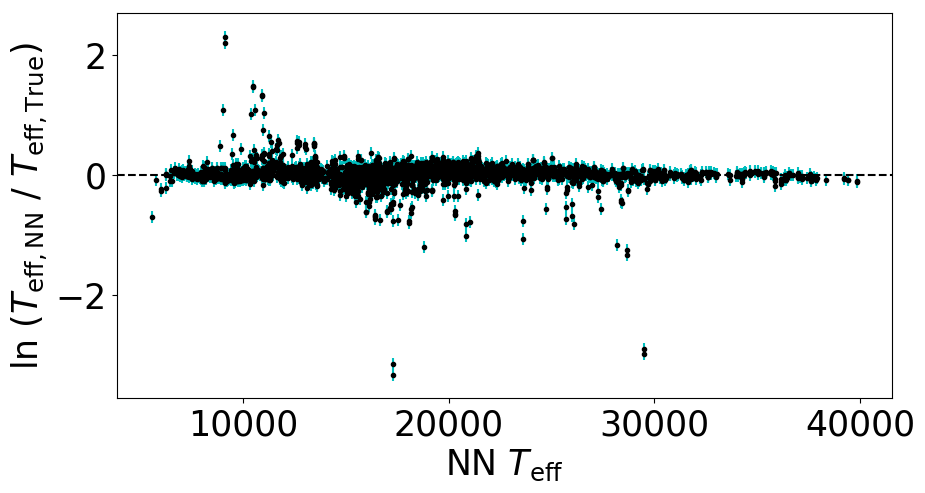

In [51]:
plt.figure(figsize = (10,5))
resid = np.abs(preds[:,0]**2/truths[:,0]**2)
plt.errorbar(truths[:,0],np.log(resid),color='k', linestyle = "None", marker = '.', yerr = np.repeat(0.1,len(resid)), ecolor='c')
plt.axhline(0, color = 'k', linestyle = '--')
plt.xlabel("NN $T_{\mathrm{eff}}$")
plt.ylabel("$\ln$ ($T_{\mathrm{eff,NN}}$ / $T_{\mathrm{eff,True}}$)")

In [54]:
%%time

bootstrap(wdtable['normspectrum'][0:100])

CPU times: user 258 ms, sys: 26.5 ms, total: 284 ms
Wall time: 115 ms


(array([[1.4394141e+04, 8.1040859e+00],
        [1.4259869e+04, 8.0870533e+00],
        [1.4397025e+04, 8.0815735e+00],
        [1.3720894e+04, 8.1022625e+00],
        [1.3697328e+04, 8.0687532e+00],
        [1.3999323e+04, 8.0950336e+00],
        [1.6266995e+04, 8.4017935e+00],
        [1.7115602e+04, 8.4487839e+00],
        [1.6430398e+04, 8.4025650e+00],
        [1.6946410e+04, 8.4378986e+00],
        [1.7000256e+04, 8.4267769e+00],
        [1.5886943e+04, 8.4353876e+00],
        [2.0295369e+04, 8.0894432e+00],
        [1.1469197e+04, 8.2708073e+00],
        [1.3855505e+04, 8.2557669e+00],
        [1.1619260e+04, 8.2748108e+00],
        [1.2545584e+04, 8.1414843e+00],
        [1.1525326e+04, 8.2642183e+00],
        [1.3500514e+04, 8.1406546e+00],
        [1.3526903e+04, 8.1071072e+00],
        [9.1151406e+03, 8.1031427e+00],
        [1.2231851e+04, 8.2749224e+00],
        [1.8121316e+04, 7.9964609e+00],
        [2.7891531e+04, 8.0314131e+00],
        [2.5251254e+04, 7.9091539e+00],


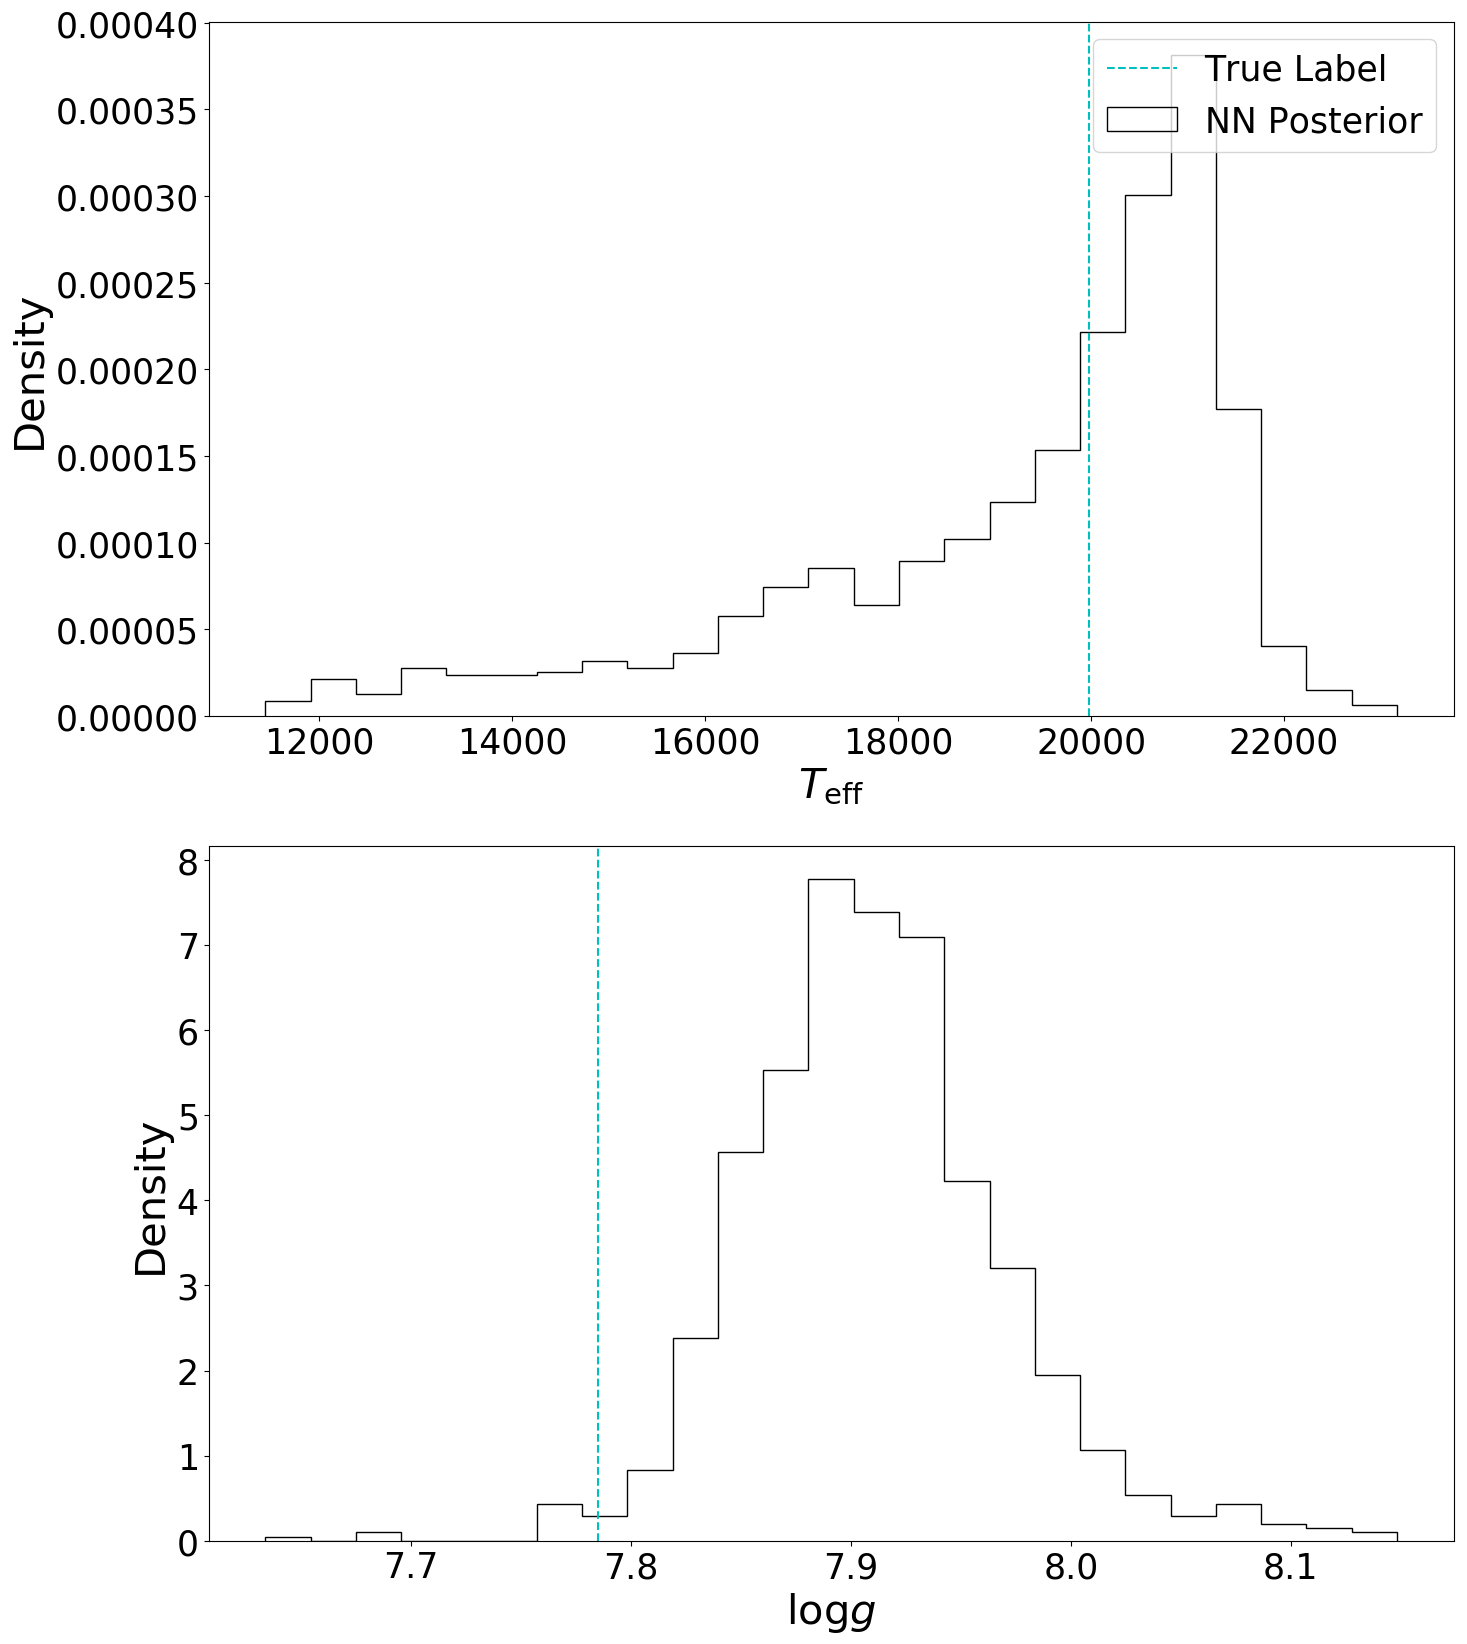

In [60]:
n = np.random.randint(0,len(wdtable))
labels = [sc.inverse_transform(model.predict(wdtable['normspectrum'][n].reshape(1,-1)))[0] for i in range(1000)]
labels = np.asarray(labels)
plt.figure(figsize=(15,17))

plt.subplot(211)
plt.hist(labels[:,0], bins = 25 ,histtype = 'step', color = 'k', label = 'NN Posterior', density = True);
plt.axvline(wdtable['spec_Teff'][n], linestyle = '--', color = 'c', label = 'True Label')
plt.legend()
plt.xlabel('$T_{\mathrm{eff}}$',fontsize = 30)
plt.ylabel('Density', fontsize = 30)

plt.subplot(212)
plt.hist(labels[:,1], bins = 25 ,histtype = 'step', color = 'k', label = 'NN Posterior', density = True);
plt.axvline(wdtable['spec_logg'][n], linestyle = '--', color = 'c', label = 'True Label')
plt.xlabel('$\log{g}$',fontsize = 30)
plt.ylabel('Density', fontsize = 30)

plt.tight_layout()
#plt.savefig('bayNN_posterior.pdf')